# Implementing the magic plot and time methods

In [1]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=7076d4631c51407592455e9cf538a1faa13e2d22bd3cfee75427c3e22b8cfad6
  Stored in directory: /root/.cache/pip/wheels/28/3a/38/7ecc013df8b58518cf859fb86c67c53df318426e96bb9fe1c0
Successfully built ipython-autotime


#  ***Importing the Required Dependecies***

In [2]:
import numpy as np 
import pandas as pd 
import os,re
import unicodedata
import gc
import time

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy

from numba import jit, cuda 

time: 12.8 s


# Detect hardware, return appropriate distribution strategy


In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
time: 3.29 s


# Reading the required datasets using pandas dataframe

**Downlading the translated Datasets**

*Link* - https://www.kaggle.com/kashnitsky/jigsaw-multilingual-toxic-test-translated/

In [4]:
# the data paths
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
translated_data_path = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

# loading all the train datasets

train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
# train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path + 'validation.csv')
# validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')
valid_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_valid_translated.csv')

# test_data1 = pd.read_csv(data_path + 'test.csv')
# test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')
test_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_test_translated.csv')

time: 23.6 s


# Preparation of Data

1.1. Gathering all the data and spliting into train, val and test

In [5]:
train_data3 = train_data3[['comment_text','toxic']].sample(frac=1).iloc[:368451,:].reset_index(drop=True)
train_data3.head()

,comment_text,toxic
0,"Well, just the Paula Jones affair cost him $94...",0.0
1,Mr. Bill's OURS blog\nOn the move again! \nIts...,0.0
2,"Good News for Alaska ~ Oil @ $50.00. $65.00, B...",0.0
3,And after all those hundreds of years of colon...,0.0
4,"The Liberals are using marijuana ""legalization...",0.0


time: 1.04 s


In [6]:
comments = np.concatenate((np.array(train_data1['comment_text']),
                           np.array(train_data3['comment_text']),
                           np.array(valid_translated['translated'])))
print('Comments shape = ',comments.shape)

train_data1['toxic'] = np.where(train_data1['toxic'] > 0.5, 1, 0)
train_data3['toxic'] = np.where(train_data3['toxic'] > 0.5, 1, 0)
valid_translated['toxic'] = np.where(valid_translated['toxic'] > 0.5, 1, 0)

toxic_labels = np.concatenate((np.array(train_data1['toxic'],dtype=int),
                               np.array(train_data3['toxic'],dtype=int),
                               np.array(valid_translated['toxic'],dtype=int)))
print('Toxic labels shape = ',toxic_labels.shape)

data = pd.DataFrame(columns=['comments','toxic'])
data['comments'] = comments
data['toxic'] = toxic_labels

Comments shape =  (600000,)
Toxic labels shape =  (600000,)
time: 391 ms


In [7]:
np.random.seed(2048)
train, valid, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

# train, valid= np.split(data.sample(frac=1), [int(.8*len(data))])

print("Train rows = ", train.shape[0])
print("validate rows = ", valid.shape[0])
print("Test rows = ", test.shape[0])

Train rows =  480000
validate rows =  60000
Test rows =  60000
time: 276 ms


**Train, Validation and Test data and labels**

In [8]:
x_train,y_train = train['comments'],np.array(train.iloc[:,1:])
x_valid,y_valid = valid['comments'],np.array(valid.iloc[:,1:])
x_test, y_test = test['comments'],np.array(test.iloc[:,1:])

print('Comment_text shapes')
print('x_train shape = ',x_train.shape)
print('x_valid shape = ',x_valid.shape)
print('x_test shape = ',x_test.shape)
print('-'*35)
print('Labels shapes')
print('y_train shape = ',y_train.shape)
print('y_valid shape = ',y_valid.shape)
print('y_test shape = ',y_test.shape)

Comment_text shapes
x_train shape =  (480000,)
x_valid shape =  (60000,)
x_test shape =  (60000,)
-----------------------------------
Labels shapes
y_train shape =  (480000, 1)
y_valid shape =  (60000, 1)
y_test shape =  (60000, 1)
time: 12.4 ms


In [9]:
del train_data1
del train_data3
del valid_translated
del data
gc.collect()

0

time: 221 ms


Final Data to predict

In [10]:
final_test_data = np.array(test_translated['translated'])
print("Shape of final_test_data: ", final_test_data.shape)

Shape of final_test_data:  (63812,)
time: 3.21 ms


# Processing and Tokenizing the Data

**Functions to clean the data**

In [11]:
# Stopword list
pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    #replacing email addresses with blank space
    w = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}"," ",w)
    
    #replacing urls with blank space
    w = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)"," ",w)
    
    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing all the stopwords
    w = pattern.sub('',w)
    
    # removes all the punctuations
    w = re.sub(r"[^a-zA-Z]+", " ", w)
    
    w = w.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     w = '<start> ' + w + ' <end>'
    
    return w

preprocess_sentence_vect = np.vectorize(preprocess_sentence)

time: 27.7 ms


# Processing and Tokenizing training, validation and testing data

In [12]:
def fast_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = preprocess_sentence_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.6 ms


In [13]:
x_train = fast_clean(x_train)


time: 3min 37s


In [14]:
x_valid = fast_clean(x_valid)


time: 28.6 s


In [15]:
x_test = fast_clean(x_test)


time: 28.4 s


In [16]:
final_test_data = fast_clean(final_test_data)


time: 48.5 s


ii. Perform tokenization by concatenating all the data

In [17]:
vocab_size = 50000
MAX_LEN = 128
trunc_type='post'

time: 955 µs


In [18]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

time: 1.52 ms


In [19]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

time: 2.62 ms


In [20]:
# defining the tokenizer function
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-large-uncased')
print(tokenizer.save_pretrained('.'))
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
print(fast_tokenizer)


('./vocab.txt', './special_tokens_map.json', './added_tokens.json')
Tokenizer(vocabulary_size=30522, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)
time: 742 ms


In [21]:
tokenizer

time: 2.79 ms


In [22]:
x_valid=fast_encode(x_valid, fast_tokenizer, maxlen=MAX_LEN)
x_test=fast_encode(x_test, fast_tokenizer, maxlen=MAX_LEN)
final_test_data = fast_encode(final_test_data, fast_tokenizer, maxlen=MAX_LEN)


time: 23.8 s


In [23]:
x_train=fast_encode(x_train, fast_tokenizer, maxlen=MAX_LEN)


time: 1min 3s


In [24]:
print('New shape of comments and labels after TOKENIZATION and PROCESSING:-')
print('-'*50)
print('Data for Training and Evaluation:\n')
print('x_train shape = ',x_train.shape)
print('x_valid shape = ',x_valid.shape)
print('x_test shape = ',x_test.shape)
print('-'*35)
print('Labels shapes')
print('y_train shape = ',y_train.shape)
print('y_valid shape = ',y_valid.shape)
print('y_test shape = ',y_test.shape)
print('-'*50)
print('The Final data for Predication\n')
print('final_test_data shape = ',final_test_data.shape)

New shape of comments and labels after TOKENIZATION and PROCESSING:-
--------------------------------------------------
Data for Training and Evaluation:

x_train shape =  (480000, 128)
x_valid shape =  (60000, 128)
x_test shape =  (60000, 128)
-----------------------------------
Labels shapes
y_train shape =  (480000, 1)
y_valid shape =  (60000, 1)
y_test shape =  (60000, 1)
--------------------------------------------------
The Final data for Predication

final_test_data shape =  (63812, 128)
time: 4.05 ms


# **Converting all the data to Tensors**

In [25]:
AUTO = tf.data.experimental.AUTOTUNE
EPOCHS = 2
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

time: 923 µs


In [26]:
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(4096)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((x_test,y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

final_test_data = (
    tf.data.Dataset
    .from_tensor_slices(final_test_data)
    .batch(BATCH_SIZE)
)

time: 3.12 s


# **Creating a Model**

In [27]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
            
    out = Dense(32,activation='relu')(cls_token)
    out = Dense(16,activation='relu')(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 3.13 ms


In [28]:
with strategy.scope():
    transformer_layer = (
        transformers.TFBertModel.from_pretrained('bert-large-uncased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 1024), (None 335141888 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 335,175,233
Trainable params: 335,175,233
Non-trainable params: 0
______________________________________________

Stage 1

In [29]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    epochs=EPOCHS
)

Train for 1875 steps, validate for 235 steps
Epoch 1/2
1875/1875 [==============================] - 1281s 683ms/step - loss: 0.1245 - accuracy: 0.9534 - val_loss: 0.1043 - val_accuracy: 0.9594
Epoch 2/2
1875/1875 [==============================] - 1067s 569ms/step - loss: 0.0976 - accuracy: 0.9606 - val_loss: 0.1123 - val_accuracy: 0.9549
time: 39min 7s


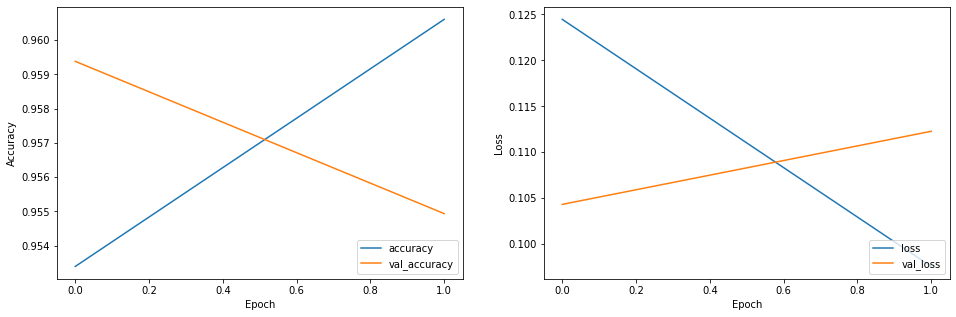

time: 495 ms


In [30]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 5))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_history.history['accuracy'], label='accuracy')
plt.plot(epochs_range,train_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_history.history['loss'], label='loss')
plt.plot(epochs_range,train_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

**Submission**

In [31]:
# submission dataset
sub1 = pd.read_csv(data_path + 'sample_submission.csv')
sub1['toxic'] = model.predict(final_test_data, verbose=1)
sub1.to_csv('submission.csv', index=False)
sub1.head(15)

250/250 [==============================] - 84s 336ms/step


,id,toxic
0,0,0.026279
1,1,0.000154
2,2,0.238488
3,3,0.000222
4,4,0.000363
5,5,0.695588
6,6,0.000227
7,7,0.000921
8,8,0.501863
9,9,0.005486


time: 1min 25s


Stage 2

In [32]:
# n_steps = x_valid.shape[0] // BATCH_SIZE
# train_history_2 = model.fit(
#     valid.repeat(),
#     steps_per_epoch=n_steps,
#     epochs=3
# )

time: 539 µs


*Evaluating the model*

In [33]:
# loss,accuracy = model.evaluate(test,verbose=1)
# print(loss,accuracy)

time: 484 µs


# Writing the predicted values to a .csv file

In [34]:
# # submission dataset
# sub2 = pd.read_csv(data_path + 'sample_submission.csv')
# sub2['toxic'] = model.predict(final_test_data, verbose=1)
# sub2.to_csv('submission.csv', index=False)
# sub2.head(15)

time: 477 µs


# Thank You 